In [2]:
import pandas as pd
from ase.db import connect
from ase import Atoms
from ase.io import read
import numpy as np
import numpy.linalg as linalg
def eig_data(atoms):
    init_R = atoms.positions
    init_Z = atoms.numbers
    x_list = []
    y_list = []
    z_list = []
    M_list = []
    M_tmp = []
    M_matrix = []
    for x,y,z in init_R:
        x_list.append(x)
        y_list.append(y)
        z_list.append(z)
    order=0
    for xl,yl,zl,Z in zip(x_list,y_list,z_list,init_Z):
        M_list.append((order,xl,yl,zl,Z))
        order+=1
    for order,x,y,z,charge in M_list:
        r = np.array((x,y,z))
        M_tmp = []
        for oorder,ox,oy,oz,ocharge in M_list:
            if oorder == order:
                IJ = 0.5*ocharge**2.4
                M_tmp.append(IJ)
            else:
                otr = np.array((ox,oy,oz))
                dist = np.linalg.norm(r-otr)
                InJ = (charge*ocharge)/dist
                M_tmp.append(InJ)
        M_matrix.append(M_tmp)
    M = np.array(M_matrix)
    w,v = np.linalg.eig(M)
    w_sort = np.sort(w)[::-1]
#    print(np.amax(w_sort))
    return w_sort
res = connect('c2db.db')
df = []
for row in res.select():
    atoms = row.toatoms()
    i = row.id
    cm = eig_data(atoms)
    if cm.shape[0] != 3:
        continue
    f = row.formula
    E = row.energy
    g = row.gap
    w = row.workfunction
    s = row.spacegroup
    df.append({'id': i, 'fingerprint':cm, 'formula':f, 'energy': E, 'band_gap':g, 'work_function':w, 'space_group':s})
df = pd.DataFrame(df)

In [3]:
print(df.describe())
df

                id       energy     band_gap  work_function
count  1228.000000  1228.000000  1228.000000    1228.000000
mean   1893.764658   -14.202319     0.429839       5.025139
std    1104.419358     4.881739     1.014154       0.983082
min      13.000000   -29.318467     0.000000       2.487626
25%     876.750000   -17.466914     0.000000       4.378386
50%    1830.500000   -13.846528     0.000000       4.974134
75%    2876.250000   -10.571678     0.178327       5.594821
max    3739.000000    -4.345323     6.450904       8.225835


id                                        fingerprint formula  \
0       13  [3137.228031104635, 2155.3999917667084, 1820.5...  AsBrSe   
1       14  [20370.830953982968, 6447.831911904273, 2460.3...  BiBrTe   
2       15  [6662.771284638622, 2374.908639439283, 925.016...  CrSeTe   
3       16  [20329.53124816473, 6391.025122562292, 3653.37...  BiMoSb   
4       17  [7061.6396852566395, 3550.706004309225, 423.17...   NbClI   
...    ...                                                ...     ...   
1223  3735  [17918.33930504896, 8.735564996221633, 4.29314...   AuLi2   
1224  3736  [14341.335667029429, 8.112105833861888, 5.1410...   HfLi2   
1225  3737  [1486.8043850781667, 0.6793782376238223, -0.03...    NiH2   
1226  3738  [4398.262856761632, 0.7172396365462136, 0.0320...    RuH2   
1227  3739  [15315.505529327804, 0.745674719418771, 0.0707...     WH2   

         energy  band_gap  work_function space_group  
0    -10.613931  1.228200       5.266643        P3m1  
1    -10.975266  0.629904       5.587519        P3m1  
2    -16.618984  0.000000       4.576962        P3m1  
3    -19.491637  0.000000       4.416695        P3m1  
4    -15.141347  0.000000       3.818156        P3m1  
...         ...       ...            ...         ...  
1223  -7.323839  0.000000       2.762386       P-6m2  
1224 -10.344351  0.000000       2.487626       P-6m2  
1225 -13.674328  0.000000       4.751586       P-6m2  
1226 -15.265764  0.000000       5.321232       P-6m2  
1227 -16.834813  0.000000       4.527930       P-6m2  

[1228 rows x 7 columns]

In [4]:
import numpy as np

# feature transformation (mean = 0, stdev = 1, feature in a same scale so no need to use minmaxscaler)
def feature_transform(x):
    y = (x - np.mean(x)) / np.std(x)
    return y

X0 = np.array(df['fingerprint'].tolist())
x1 = feature_transform([i[0] for i in X0])
x2 = feature_transform([i[1] for i in X0])
x3 = feature_transform([i[2] for i in X0])
X = np.array([x1,x2,x3]).T

In [5]:
# Linear ridge regression model
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import math

# mean loss function as generalization error (algorithm 5)
def my_scorer(y_true, y_predicted):
    error = np.mean((y_true - y_predicted)**2)
    return error
my_func = make_scorer(my_scorer, greater_is_better=False)

# Linear Regression (Energy vs. Coloumb matrix)
y = df['energy']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# create model
model = Ridge()
# define the grid search hyperparameters (regularization parameter alpha)
hyperparameters = {'alpha':[0.1, 1, 5, 10, 15, 20, 25, 30]}
grid = GridSearchCV(model, param_grid=hyperparameters, scoring=my_func, cv=10)
grid_result = grid.fit(X_train, y_train)
# summarize results (the score should be interpreted as the gereralization error)
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
mses = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print(mses)
for mse, stdev, param in zip(mses, stds, params):
    print("mse: %f (stdev: %f) with hyperparameter: %r" % (-mse, stdev, param))

Best: 22.386700 using {'alpha': 15}
[-22.39085842 -22.39032978 -22.38844445 -22.38707744 -22.38670031
 -22.38720763 -22.38850535 -22.39050938]
mse: 22.390858 (stdev: 2.873366) with hyperparameter: {'alpha': 0.1}
mse: 22.390330 (stdev: 2.873453) with hyperparameter: {'alpha': 1}
mse: 22.388444 (stdev: 2.873927) with hyperparameter: {'alpha': 5}
mse: 22.387077 (stdev: 2.874704) with hyperparameter: {'alpha': 10}
mse: 22.386700 (stdev: 2.875666) with hyperparameter: {'alpha': 15}
mse: 22.387208 (stdev: 2.876792) with hyperparameter: {'alpha': 20}
mse: 22.388505 (stdev: 2.878066) with hyperparameter: {'alpha': 25}
mse: 22.390509 (stdev: 2.879471) with hyperparameter: {'alpha': 30}


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


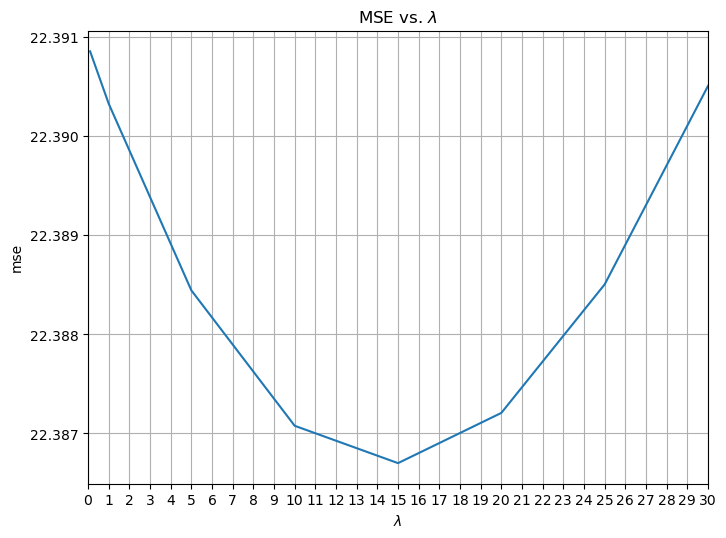

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot generalization error vs. regularization hyperparameter lambda
plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot([0.1, 1, 5, 10, 15, 20, 25, 30], -mses)
plt.title(r'MSE vs. $\lambda$');
plt.xlabel(r'$\lambda$');
plt.ylabel('mse');
plt.grid()
plt.xlim([0, 30])
plt.xticks(np.arange(0, 31, 1))
plt.savefig('mse_lambda.png')
plt.show()

In [7]:
from sklearn import metrics

# best linear ridge regression model
best_linear_model = Ridge(alpha=15)
best_linear_model.fit(X_train, y_train)
print('The intercept of the best linear regression model is {0} '.format(best_linear_model.intercept_))
print('The coefficients of the best linear regression model are {0}'.format(best_linear_model.coef_))

# test the model on test set
y_pred = best_linear_model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

The intercept of the best linear regression model is -14.155675415959303 
The coefficients of the best linear regression model are [ 0.09006492 -1.02921562  1.71110927]
Mean Absolute Error: 3.706686766096255
Mean Squared Error: 21.95037868296676
Root Mean Squared Error: 4.685123123565352


In [8]:
# Baseline Linear Regression
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import math
from statistics import variance
from random import randrange

# generalization error as generalization error (algorithm 6)
def my_scorer(y_true, y_predicted):
    error = np.mean((y_true - y_predicted)**2) + variance(y_true) + variance(y_predicted)
    return error
my_func = make_scorer(my_scorer, greater_is_better=False)
 
# zero rule algorithm for regression
def zero_rule_algorithm_regression(train, test):
    output_values = [row for row in train]
    prediction = sum(output_values) / float(len(output_values))
    predicted = [prediction for i in range(len(test))]
    return predicted

# Baseline Linear Regression (only consider Energy)
y = df['energy']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# baseline model predictions 
predictions = zero_rule_algorithm_regression(y_train, y_test)
mse = my_scorer(y_test, predictions)
print('mean: {0}'.format(set(predictions)))
print('Generalization error: {0}'.format(mse))

mean: {-14.156746976886545}
Generalization error: 46.97338318551178


In [9]:
# ANN model
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import math

# mean squared (test) error as generalization error (algorithm 6)
def my_scorer(y_true, y_predicted):
    error = np.mean((y_true - y_predicted)**2) + variance(y_true) + variance(y_predicted)    
    return error
my_func = make_scorer(my_scorer, greater_is_better=False)

# Linear Regression (Energy vs. Coloumb matrix)
y = df['energy']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# create model
model = MLPRegressor(max_iter=1000)
# define the grid search hyperparameters (regularization parameter alpha)
hyperparameters = {'hidden_layer_sizes': [(1,),(5,),(10,),(30,),(50,),(70,),(100,)], 'activation': ['logistic', 'relu'], 'solver': ['lbfgs'], 'alpha': [0.0001,0.001,0.01,0.05, 0.1]}
grid = GridSearchCV(model, param_grid=hyperparameters, scoring=my_func, cv=10)
grid_result = grid.fit(X_train, y_train)
# summarize results (the score should be interpreted as the gereralization error)
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
mses = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print(mses)
for mse, stdev, param in zip(mses, stds, params):
    print("Generalization error: %f (stdev: %f) with hyperparameter: %r" % (-mse, stdev, param))

C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 47.992048 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}
[-48.45753991 -49.15920888 -50.35972039 -50.89584181 -51.58846292
 -51.51277205 -52.06366807 -48.2906542  -49.72202924 -49.67159154
 -52.10696169 -51.48770281 -50.57587531 -50.09936634 -48.07139353
 -49.15940316 -49.94413338 -50.71859349 -50.53550775 -49.52510151
 -51.04133419 -48.21431492 -49.42661797 -48.72121604 -48.81546149
 -49.92727498 -49.71997781 -48.83552766 -48.81280652 -48.50423218
 -49.41439278 -48.82589597 -48.580437   -48.04003227 -47.99204789
 -48.63456013 -48.42875644 -49.59299446 -49.70478497 -50.54216655
 -51.16310414 -49.02528437 -48.06708091 -48.34516323 -49.85459215
 -50.29235242 -49.97921017 -49.17923576 -49.9182533  -48.22697058
 -48.67293954 -49.98364879 -49.45372062 -49.30565318 -48.95886956
 -49.887483   -48.22590804 -48.9482986  -48.94967205 -49.24014361
 -49.19552717 -49.31572393 -49.81841627 -48.28193395 -48.68127432
 -49.58292039 -49.6931366  -49

In [18]:
from sklearn import metrics

# best ANN model
best_ann_model = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', alpha=0.1, max_iter=1000)
best_ann_model.fit(X_train, y_train)
print('The intercept of the best ANN model is {0} '.format(best_ann_model.intercepts_))
print('The coefficients of the best ANN model are {0}'.format(best_ann_model.coefs_))

# test the model on test set
y_pred = best_ann_model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

The intercept of the best ANN model is [array([ 0.21601264,  0.29335015, -0.12969234,  0.34811631,  0.26652217,
        0.40027342,  0.17077683,  0.04728984,  0.13013317, -0.00344454,
        0.41993197,  0.41059805,  0.26297231,  0.22164247, -0.18342374,
        0.21270629,  0.41275021, -0.00910887,  0.27417175,  0.33657877,
        0.37796312, -0.06594055,  0.03907875,  0.04477413,  0.055864  ,
        0.20671268,  0.13139748,  0.09126076,  0.02918894,  0.29392339,
        0.22250039,  0.32094839,  0.37116883,  0.1268062 ,  0.36059168,
        0.21148051,  0.32423296, -0.09060336,  0.42392815,  0.2918447 ,
        0.025336  ,  0.3185798 ,  0.21356376,  0.42840918, -0.11643985,
        0.05481563,  0.27970312, -0.06108784,  0.29749382,  0.161756  ,
       -0.0464924 ,  0.36822591,  0.41771282,  0.20873236,  0.10180971,
        0.263888  ,  0.0997484 ,  0.4295223 ,  0.22204989,  0.38658775,
       -0.00377612,  0.21600532,  0.06872846,  0.3868931 ,  0.25954132,
        0.31212273,  0.2

In [11]:
# 2-level k-fold cross-validation for ANN model
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import math

# mean squared (test) error as generalization error (algorithm 6)
def my_scorer(y_true, y_predicted):
    error = np.mean((y_true - y_predicted)**2) + variance(y_true) + variance(y_predicted)
    return error
my_func = make_scorer(my_scorer, greater_is_better=False)

# outer cross validation
kfold = KFold(10, shuffle=True, random_state=42)
# enumerate splits
for train_index, test_index in kfold.split(X):
    print("Train index:", train_index, "Test index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    # create model
    model = MLPRegressor(max_iter=1000)
    # define the grid search hyperparameters (regularization parameter alpha)
    hyperparameters = {'hidden_layer_sizes': [(1,),(5,),(10,),(30,),(50,),(70,),(100,)], 'activation': ['logistic'], 'solver': ['lbfgs'], 'alpha': [0.0001,0.001,0.01,0.05, 0.1]}
    grid = GridSearchCV(model, param_grid=hyperparameters, scoring=my_func, cv=10)
    grid_result = grid.fit(X_train, y_train)
    # summarize results (the score should be interpreted as the gereralization error)
    print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
    print('\n')

Train index: [   0    1    2 ... 1225 1226 1227] Test index: [  23   43   44   49   51   54   56   58   63   70   76   78   81   86
  101  107  109  113  123  128  155  168  170  174  192  209  210  233
  243  244  265  290  303  306  323  327  352  355  358  365  371  376
  377  382  390  405  420  433  438  439  447  451  458  482  485  486
  493  497  506  523  535  541  542  549  551  581  585  589  599  605
  609  626  667  678  682  695  707  710  723  767  777  803  808  834
  859  868  876  886  902  908  918  925  945  947  958  963 1003 1018
 1026 1032 1033 1049 1053 1068 1084 1085 1093 1096 1099 1124 1135 1162
 1165 1169 1171 1172 1173 1177 1180 1213 1214 1216 1219]


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 47.833621 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}


Train index: [   0    1    2 ... 1225 1226 1227] Test index: [  10   31   88   96  135  140  147  156  158  163  178  184  196  198
  199  208  218  220  231  240  247  266  270  275  277  286  289  292
  294  296  297  298  309  321  332  342  344  361  363  367  381  394
  398  409  413  422  423  427  428  430  432  442  453  461  479  490
  513  519  533  534  545  578  583  588  615  644  651  661  671  692
  701  720  727  732  736  745  770  771  785  806  809  814  829  830
  836  847  862  872  879  900  905  911  933  936  942  953  962  979
  983  984  986  996  999 1005 1007 1008 1019 1034 1039 1054 1088 1092
 1094 1102 1121 1139 1147 1150 1158 1174 1178 1190 1195]


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 47.383756 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}


Train index: [   0    1    2 ... 1225 1226 1227] Test index: [   3    5   12   30   39   59   66   67   83  100  129  136  138  139
  141  211  224  227  237  242  259  260  273  274  299  308  310  314
  319  328  331  333  350  362  411  415  424  425  462  481  528  532
  536  543  553  560  567  570  572  582  594  597  598  610  613  628
  631  643  650  665  668  676  677  712  715  718  722  728  730  737
  755  759  762  764  772  778  780  783  788  796  811  818  832  846
  849  861  865  881  903  916  922  932  935  944  969  973  978 1004
 1024 1036 1047 1052 1058 1060 1061 1066 1070 1074 1077 1083 1101 1112
 1137 1141 1146 1163 1164 1182 1191 1196 1199 1220 1221]


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 46.070853 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (70,), 'solver': 'lbfgs'}


Train index: [   0    1    3 ... 1225 1226 1227] Test index: [   2    6   25   27   29   47   55   60   72   80   92   97  106  110
  120  137  165  182  183  204  213  215  239  248  256  261  280  285
  291  307  311  316  318  325  334  336  339  346  351  354  359  370
  380  410  429  435  464  465  467  471  478  494  514  522  526  527
  529  538  548  552  554  558  561  575  590  591  593  621  622  630
  649  652  660  673  708  713  716  717  724  756  760  765  802  813
  820  825  841  848  864  873  884  894  901  904  912  926  940  961
  966  974  977  980  982  992  994 1000 1001 1050 1055 1063 1100 1106
 1113 1116 1142 1143 1144 1168 1187 1192 1202 1209 1215]


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 48.277209 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}


Train index: [   1    2    3 ... 1225 1226 1227] Test index: [   0    7    9   33   62   65   71   77   79   82   84   94  104  118
  133  144  145  148  177  212  221  223  228  235  238  249  250  254
  258  281  302  305  312  329  347  357  373  386  388  389  404  408
  436  440  445  448  449  457  460  477  501  504  507  525  531  539
  557  566  573  584  596  602  614  617  618  620  629  634  636  654
  666  679  693  704  706  714  721  731  738  741  746  752  753  774
  781  807  839  844  845  852  857  867  874  875  888  898  921  924
  938  939  949  952  959  965  987  991 1009 1010 1067 1091 1098 1110
 1118 1125 1127 1131 1134 1145 1167 1183 1185 1205 1222]


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 46.930458 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (70,), 'solver': 'lbfgs'}


Train index: [   0    1    2 ... 1224 1226 1227] Test index: [  18   24   28   41   61   69   73   74   89   90  108  114  125  131
  132  164  169  172  173  176  181  185  193  214  232  234  251  264
  272  278  300  326  338  360  366  368  375  383  393  395  412  414
  417  444  450  454  456  468  475  483  491  495  498  499  500  516
  518  530  547  568  587  595  601  604  616  657  670  675  688  694
  700  711  735  739  743  754  768  787  793  798  812  816  838  843
  855  858  869  885  887  889  890  906  909  910  923  927  930  934
  948  968  985  990  997  998 1015 1029 1035 1040 1046 1048 1079 1109
 1117 1120 1148 1152 1160 1175 1181 1188 1201 1204 1225]


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 47.777596 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}


Train index: [   0    1    2 ... 1225 1226 1227] Test index: [   4   11   15   22   42   46   52   57   68   75   85   93   99  102
  105  116  117  126  153  159  167  179  188  195  203  217  222  236
  257  263  267  268  271  284  304  313  324  335  340  341  349  356
  369  396  416  426  431  434  443  446  473  487  512  521  544  555
  559  571  576  580  603  607  611  619  633  635  637  655  656  674
  689  690  691  696  703  733  740  750  757  761  773  782  786  789
  790  801  819  822  823  826  837  842  850  892  893  899  914  917
  931  943  950  970  971  976 1011 1022 1023 1037 1042 1045 1069 1072
 1078 1080 1081 1103 1119 1138 1149 1186 1189 1193 1203]


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 48.087542 using {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (10,), 'solver': 'lbfgs'}


Train index: [   0    1    2 ... 1225 1226 1227] Test index: [  16   17   19   26   32   35   36   37   38   45   48   50  115  124
  127  142  149  154  157  171  175  180  190  191  194  225  229  245
  255  282  283  287  301  320  322  348  353  364  372  374  399  407
  437  469  470  476  480  489  496  505  511  515  517  537  546  569
  574  606  625  638  639  653  658  662  664  669  684  685  687  697
  726  734  744  749  758  784  792  797  799  810  817  824  827  828
  833  853  866  882  907  920  937  941  946  964  988  989  993 1006
 1013 1030 1043 1062 1065 1073 1089 1090 1097 1108 1111 1128 1132 1153
 1155 1170 1176 1179 1194 1200 1206 1207 1208 1212 1224]


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 46.768080 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}


Train index: [   0    2    3 ... 1224 1225 1227] Test index: [   1    8   53   95  103  111  112  119  122  143  146  150  151  152
  160  162  186  197  202  207  219  226  246  253  262  279  293  317
  345  384  400  402  403  419  421  441  452  463  472  484  488  503
  509  524  540  550  556  563  577  579  586  608  623  624  627  632
  640  641  645  648  659  663  672  680  681  698  705  709  748  751
  795  800  821  835  851  854  877  880  883  895  896  913  915  919
  928  951  954  956  967  972  981 1002 1012 1014 1020 1027 1031 1041
 1057 1059 1075 1087 1105 1107 1114 1115 1122 1133 1136 1140 1151 1156
 1157 1159 1161 1166 1198 1210 1217 1218 1223 1226]


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 45.455451 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}


Train index: [   0    1    2 ... 1224 1225 1226] Test index: [  13   14   20   21   34   40   64   87   91   98  121  130  134  161
  166  187  189  200  201  205  206  216  230  241  252  269  276  288
  295  315  330  337  343  378  379  385  387  391  392  397  401  406
  418  455  459  466  474  492  502  508  510  520  562  564  565  592
  600  612  642  646  647  683  686  699  702  719  725  729  742  747
  763  766  769  775  776  779  791  794  804  805  815  831  840  856
  860  863  870  871  878  891  897  929  955  957  960  975  995 1016
 1017 1021 1025 1028 1038 1044 1051 1056 1064 1071 1076 1082 1086 1095
 1104 1123 1126 1129 1130 1154 1184 1197 1211 1227]


C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 47.700865 using {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}




In [12]:
# 2-level k-fold cross-validation for linear (ridge) regression model
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import math

# mean squared (test) error as generalization error (algorithm 6)
def my_scorer(y_true, y_predicted):
    error = np.mean((y_true - y_predicted)**2) + variance(y_true) + variance(y_predicted)
    return error
my_func = make_scorer(my_scorer, greater_is_better=False)

# outer cross validation
kfold = KFold(10, shuffle=True, random_state=42)
# enumerate splits
for train_index, test_index in kfold.split(X):
    print("Train index:", train_index, "Test index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # create model
    model = Ridge()
    # define the grid search hyperparameters (regularization parameter alpha)
    hyperparameters = {'alpha':[0.1, 1, 5, 10, 15, 20, 25, 30]}
    grid = GridSearchCV(model, param_grid=hyperparameters, scoring=my_func, cv=10)
    grid_result = grid.fit(X_train, y_train)
    # summarize results (the score should be interpreted as the gereralization error)
    print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
    print('\n')

Train index: [   0    1    2 ... 1225 1226 1227] Test index: [  23   43   44   49   51   54   56   58   63   70   76   78   81   86
  101  107  109  113  123  128  155  168  170  174  192  209  210  233
  243  244  265  290  303  306  323  327  352  355  358  365  371  376
  377  382  390  405  420  433  438  439  447  451  458  482  485  486
  493  497  506  523  535  541  542  549  551  581  585  589  599  605
  609  626  667  678  682  695  707  710  723  767  777  803  808  834
  859  868  876  886  902  908  918  925  945  947  958  963 1003 1018
 1026 1032 1033 1049 1053 1068 1084 1085 1093 1096 1099 1124 1135 1162
 1165 1169 1171 1172 1173 1177 1180 1213 1214 1216 1219]
Best: 48.057103 using {'alpha': 30}


Train index: [   0    1    2 ... 1225 1226 1227] Test index: [  10   31   88   96  135  140  147  156  158  163  178  184  196  198
  199  208  218  220  231  240  247  266  270  275  277  286  289  292
  294  296  297  298  309  321  332  342  344  361  363  367  381  394
  

C:\Users\shuha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
# 2-level k-fold cross-validation for baseline linear regression model
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import math

# mean squared (test) error as generalization error (algorithm 6)
def my_scorer(y_true, y_predicted):
    error = np.mean((y_true - y_predicted)**2) + variance(y_true) + variance(y_predicted)
    return error
my_func = make_scorer(my_scorer, greater_is_better=False)

# zero rule algorithm for regression
def zero_rule_algorithm_regression(train, test):
    output_values = [row for row in train]
    prediction = sum(output_values) / float(len(output_values))
    predicted = [prediction for i in range(len(test))]
    return predicted

# outer cross validation
kfold = KFold(10, shuffle=True, random_state=42)
# enumerate splits
for train_index, test_index in kfold.split(X):
    print("Train index:", train_index, "Test index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions = zero_rule_algorithm_regression(y_train, y_test)
    mse = my_scorer(y_test, predictions)
    print('MSE: {0}\n'.format(mse))

Train index: [   0    1    2 ... 1225 1226 1227] Test index: [  23   43   44   49   51   54   56   58   63   70   76   78   81   86
  101  107  109  113  123  128  155  168  170  174  192  209  210  233
  243  244  265  290  303  306  323  327  352  355  358  365  371  376
  377  382  390  405  420  433  438  439  447  451  458  482  485  486
  493  497  506  523  535  541  542  549  551  581  585  589  599  605
  609  626  667  678  682  695  707  710  723  767  777  803  808  834
  859  868  876  886  902  908  918  925  945  947  958  963 1003 1018
 1026 1032 1033 1049 1053 1068 1084 1085 1093 1096 1099 1124 1135 1162
 1165 1169 1171 1172 1173 1177 1180 1213 1214 1216 1219]
MSE: 44.091252397092035

Train index: [   0    1    2 ... 1225 1226 1227] Test index: [  10   31   88   96  135  140  147  156  158  163  178  184  196  198
  199  208  218  220  231  240  247  266  270  275  277  286  289  292
  294  296  297  298  309  321  332  342  344  361  363  367  381  394
  398  409  413

In [19]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
import sklearn.tree
import scipy.stats
import numpy as np, scipy.stats as st

# zero rule algorithm for regression
def zero_rule_algorithm_regression(train, test):
    output_values = [row for row in train]
    prediction = sum(output_values) / float(len(output_values))
    predicted = [prediction for i in range(len(test))]
    return predicted

# select optimal models
final_ann_model = MLPRegressor(hidden_layer_sizes=(50,), activation='logistic', alpha=0.1, max_iter=1000)
final_linear_model = best_linear_model = Ridge(alpha=15)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
mA = final_ann_model.fit(X_train,y_train)
mB = final_linear_model.fit(X_train, y_train)

yhatA = mA.predict(X_test)
yhatB = mB.predict(X_test)
yhatC = zero_rule_algorithm_regression(y_train, y_test)

# perform statistical comparison of the models
# compute z with squared error.
zA = np.abs(y_test - yhatA ) ** 2
zB = np.abs(y_test - yhatB) ** 2
zC = np.abs(y_test - yhatC) ** 2

# compute confidence interval of model A
alpha = 0.05
CIA = st.t.interval(1-alpha, df=len(zA)-1, loc=np.mean(zA), scale=st.sem(zA))  # Confidence interval
CIB = st.t.interval(1-alpha, df=len(zB)-1, loc=np.mean(zB), scale=st.sem(zB))
CIC = st.t.interval(1-alpha, df=len(zC)-1, loc=np.mean(zC), scale=st.sem(zC))

print('Confidence interval of ANN model: {0} \n'.format(CIA))
print('Confidence interval of linear ridge regression model: {0} \n'.format(CIB))
print('Confidence interval of baseline model: {0}'.format(CIC))

Confidence interval of ANN model: (18.464523584300927, 24.48160238083245) 

Confidence interval of linear ridge regression model: (18.776978532723653, 25.12377883320987) 

Confidence interval of baseline model: (19.980779367960466, 26.953706613345553)


In [20]:
# ANN vs. Linear Regression
# Compute confidence interval of z = zA-zB and p-value of Null hypothesis
zA = np.abs(y_test - yhatA ) ** 2
zB = np.abs(y_test - yhatB) ** 2
z = zA - zB
CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value
print('CI = {0}, p = {1}'.format(CI, p))

CI = (-0.9583908793537697, 0.0037594785536069764), p = 0.02590440290371694


In [21]:
# ANN vs. Baseline
# Compute confidence interval of z = zA-zC and p-value of Null hypothesis
zA = np.abs(y_test - yhatA ) ** 2
zC = np.abs(y_test - yhatC) ** 2
z = zA - zC
CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value
print('CI = {0}, p = {1}'.format(CI, p))

CI = (-3.173169682269158, -0.8151903339035551), p = 0.0004822471141618764


In [22]:
# Linear Regression vs. Baseline
# Compute confidence interval of z = zB-zC and p-value of Null hypothesis
zB = np.abs(y_test - yhatB) ** 2
zC = np.abs(y_test - yhatC) ** 2
z = zB - zC
CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value
print('CI = {0}, p = {1}'.format(CI, p))

CI = (-2.7430773740947414, -0.29065124127780995), p = 0.007728223987630853
